In [1]:
import json
import numpy as np
import os

In [2]:
texts = []
labels = []
#실행 파일과 같은 폴더에 파일들이 존재해야 합니다.
for i in range(1, 20):
    file_name = f'기술_과학_{i}.json'  
    
    if os.path.exists(file_name):  # 파일이 존재하는 경우에만 처리
        with open(file_name, 'r', encoding='utf-8') as file:
            data = json.load(file)
        
        for conversation in data["dataset"].get("conversations", []):
            for utterance in conversation.get("utterances", []):
                text = utterance.get("utterance_text", "")
                evaluation = utterance.get("utterance_evaluation", [])
                if evaluation:  # 평가 대상이 아닌 문장을 제외
                    texts.append(text)
                    labels.append(evaluation)

In [3]:
#토큰화 코드: 라이브러리 사용
import konlpy 
from konlpy.tag import Okt, Hannanum, Kkma 

okt = Okt()
tokenized_texts = []

for i in range(len(texts)):
    tokenized_texts.append(okt.morphs(texts[i]))

In [4]:
#word2vec 과정
_word_to_id = {}
_id_to_word = {}

def preprocess(words): #앞에서 토큰화를 해서 적절히 바꿨습니다. 
    for word in words:
        if word not in _word_to_id:
            new_id = len(_word_to_id)
            _word_to_id[word] = new_id
            _id_to_word[new_id] = word
    corpus = np.array([_word_to_id[w] for w in words])
    return corpus, _word_to_id, _id_to_word

In [5]:
attribute_labels = {
    'linguistic_acceptability': [],
    'consistency': [],
    'interestingness': [],
    'unbias': [],
    'harmlessness': [],
    'no_hallucination': [],
    'understandability': [],
    'sensibleness': [],
    'specificity': []
}

# 속성별 레이블 추출
for i in range(len(labels)):
    # 현재 대화에 대한 속성값 초기화
    attribute_values = {key: 0 for key in attribute_labels.keys()}

    for j in range(len(labels[i])):
        for key in attribute_labels.keys():
            if labels[i][j].get(key) == 'yes':
                attribute_values[key] += 1

    # 각 속성별로 모든 발화에서 'yes'인 경우만 1, 아니면 0
    for key in attribute_labels.keys():
        if attribute_values[key] == len(labels[i]):
            attribute_labels[key].append(1)
        else:
            attribute_labels[key].append(0)

In [6]:
from common.layers import *
from common.functions import sigmoid
import sys
sys.path.append('..')
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb
from rnnlm import Rnnlm
from common.time_layers import *

class RNN:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    def forward(self, x, h_prev):
        Wx, Wh, b = self.params
        t = np.dot(h_prev, Wh) + np.dot(x, Wx) + b
        h_next = np.tanh(t)

        self.cache = (x, h_prev, h_next)
        return h_next

    def backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache

        dt = dh_next * (1 - h_next ** 2)
        db = np.sum(dt, axis=0)
        dWh = np.dot(h_prev.T, dt)
        dh_prev = np.dot(dt, Wh.T)
        dWx = np.dot(x.T, dt)
        dx = np.dot(dt, Wx.T)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        return dx, dh_prev
class SimpleRnnlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 가중치 초기화
        embed_W = (rn(V, D) / 100).astype('f')
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f')
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f')
        rnn_b = np.zeros(H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]

        # 모든 가중치와 기울기를 리스트에 모은다.
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, ts):
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.rnn_layer.reset_state()        

In [7]:
batch_size = 10
wordvec_size = 100
hidden_size = 100  # RNN의 은닉 상태 벡터의 원소 수
time_size = 5  # RNN을 펼치는 크기
lr = 0.1
max_epoch = 40

In [8]:
model = SimpleRnnlm(10000, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

for i in range(len(tokenized_texts)): #마지막은 테스트로 사용
    corpus, word_to_id, id_to_word = preprocess(tokenized_texts[i])
    xs = corpus[:-1]
    ts = corpus[1:]
    trainer.fit(xs, ts, max_epoch, batch_size, time_size)

| 에폭 81 |  반복 1 / 1 | 시간 0[s] | 퍼플렉서티 9971.61
| 에폭 82 |  반복 1 / 1 | 시간 0[s] | 퍼플렉서티 9868.05
| 에폭 83 |  반복 1 / 1 | 시간 0[s] | 퍼플렉서티 9737.54
| 에폭 84 |  반복 1 / 1 | 시간 0[s] | 퍼플렉서티 9629.82
| 에폭 85 |  반복 1 / 1 | 시간 0[s] | 퍼플렉서티 9303.38
| 에폭 86 |  반복 1 / 1 | 시간 0[s] | 퍼플렉서티 8943.59
| 에폭 87 |  반복 1 / 1 | 시간 0[s] | 퍼플렉서티 9169.65
| 에폭 88 |  반복 1 / 1 | 시간 0[s] | 퍼플렉서티 8561.13
| 에폭 89 |  반복 1 / 1 | 시간 0[s] | 퍼플렉서티 8031.50
| 에폭 90 |  반복 1 / 1 | 시간 0[s] | 퍼플렉서티 7613.75
| 에폭 91 |  반복 1 / 1 | 시간 0[s] | 퍼플렉서티 7612.08
| 에폭 92 |  반복 1 / 1 | 시간 0[s] | 퍼플렉서티 6469.85
| 에폭 93 |  반복 1 / 1 | 시간 0[s] | 퍼플렉서티 5165.13
| 에폭 94 |  반복 1 / 1 | 시간 0[s] | 퍼플렉서티 5646.89
| 에폭 95 |  반복 1 / 1 | 시간 0[s] | 퍼플렉서티 5165.78
| 에폭 96 |  반복 1 / 1 | 시간 0[s] | 퍼플렉서티 3778.86
| 에폭 97 |  반복 1 / 1 | 시간 0[s] | 퍼플렉서티 3308.78
| 에폭 98 |  반복 1 / 1 | 시간 0[s] | 퍼플렉서티 3309.03
| 에폭 99 |  반복 1 / 1 | 시간 0[s] | 퍼플렉서티 3072.09
| 에폭 100 |  반복 1 / 1 | 시간 0[s] | 퍼플렉서티 2012.41
| 에폭 101 |  반복 1 / 1 | 시간 0[s] | 퍼플렉서티 1660.45
| 에폭 102 |  반복 1 / 1 | 시간 0[s] |

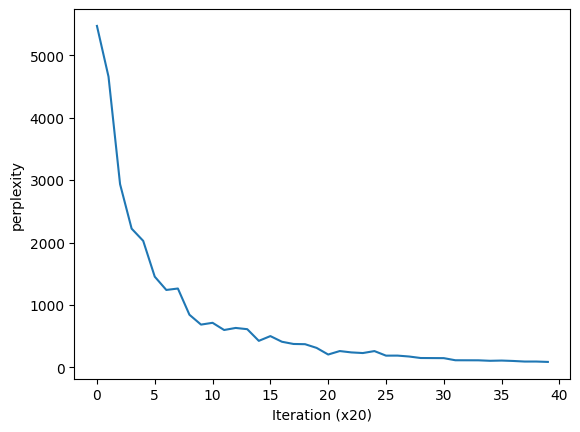

In [9]:
trainer.plot()